# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [1]:
import os
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
import pandas as pd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)

# 设置数据目录
survival_type = 'OS'
task_type = f'MIL-{survival_type}_'
# 对应的标签文件
group_info = get_param_in_cwd('dataset_column') or 'group'
survival_data = pd.read_csv(get_param_in_cwd('survival_file'))[['ID', survival_type, f"{survival_type}TIME"]]
labelf = 'group.csv'
# 读取标签数据列名
labels = [get_param_in_cwd('task_column') or 'label']

# 读取特征

In [2]:
from collections import namedtuple
import onekey_algo.custom.components as okcomp
from onekey_algo import OnekeyDS as okds
from onekey_algo.custom.utils import print_join_info
from onekey_algo import get_param_in_cwd

import pandas as pd
import numpy as np
import os
os.makedirs('img', exist_ok=True)
os.makedirs('features', exist_ok=True)


prob_histo = pd.read_csv(f'features/rad_prob_histogram.csv')
prob_tfidf = pd.read_csv(f'features/rad_prob_tfidf.csv')
prob = pd.merge(prob_histo, prob_tfidf, on='ID', how='inner', suffixes=['_histo', '_tfidf'])
prob['ID'] = prob['ID'].astype(str)

pred_histo = pd.read_csv(f'features/rad_pred_histogram.csv')
pred_tfidf = pd.read_csv(f'features/rad_pred_tfidf.csv')
pred = pd.merge(pred_histo, pred_tfidf, on='ID', how='inner', suffixes=['_histo', '_tfidf'])
pred['ID'] = pred['ID'].astype(str)

features = pd.merge(prob, pred, on='ID', how='inner')
features.to_csv('features/rad_features.csv', index=False, header=True)
labels = ['label']
featrues_not_use = ['ID']
features

,ID,prob-0.0,prob-0.01,prob-0.02,prob-0.03,prob-0.04,prob-0.05,prob-0.06,prob-0.07,prob-0.08,...,prob095,prob096,prob097,prob098,prob099,prob10,pred-0,pred-1,pred0,pred1
0,primary-1.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.286,0.714,0.129,0.992
1,primary-10.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
2,primary-100.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
3,primary-101.nii.gz,0.0,0.0,0.429,0.143,0.143,0.0,0.143,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
4,primary-102.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,secondary2-70.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
499,secondary2-71.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
500,secondary2-72.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.000,1.000,0.000
501,secondary2-8.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.857,0.143,0.891,0.455


In [3]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

event_col = survival_type
duration_col = f"{survival_type}TIME"
label_data = pd.read_csv(labelf)[['ID', 'group']]
data = pd.merge(features[[c for c in features.columns if c not in ['label']]], survival_data, on='ID', how='inner')
data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,prob-0.0,prob-0.01,prob-0.02,prob-0.03,prob-0.04,prob-0.05,prob-0.06,prob-0.07,prob-0.08,...,prob098,prob099,prob10,pred-0,pred-1,pred0,pred1,OS,OSTIME,group
0,primary-1.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.286,0.714,0.129,0.992,1,20,train
1,primary-10.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,48,train
2,primary-100.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,1,28,train
3,primary-101.nii.gz,0.0,0.0,0.429,0.143,0.143,0.0,0.143,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,55,val
4,primary-102.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,1,15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-69.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,0.714,0.286,0.632,0.775,0,40,test
454,secondary2-7.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,52,test
455,secondary2-71.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.143,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,39,test
456,secondary2-72.nii.gz,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,...,0.0,0.0,0.0,1.000,0.000,1.000,0.000,0,38,test


In [4]:
import os
from onekey_algo.custom.components.comp1 import normalize_df, select_feature

corr_name = get_param_in_cwd('corr_name', 'spearman')
if os.path.exists(f'features/{task_type}features_corrsel.csv') and False:
    data = pd.read_csv(f'features/{task_type}features_corrsel.csv', header=0)
else:
    tgroup = data[data['group'] == 'train']
    sel_feature = select_feature(tgroup[[c for c in tgroup.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                                 threshold=0.9, topn=128, verbose=False)
    data = data[['ID'] + sel_feature + [event_col, duration_col, group_info]]
    data.to_csv(f'features/{task_type}features_corrsel.csv', header=True, index=False)
data

,ID,prob00,prob002,prob003,prob004,prob005,prob006,prob007,prob008,prob009,...,prob083,prob084,prob088,prob089,prob093,prob10,pred1,OS,OSTIME,group
0,primary-1.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.413,0.433,0.0,0.0,0.0,0.992,1,20,train
1,primary-10.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,48,train
2,primary-100.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.314,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,1,28,train
3,primary-101.nii.gz,0.0,0.898,0.261,0.232,0.0,0.193,0.185,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,55,val
4,primary-102.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,1,15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,secondary2-69.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.244,...,0.0,0.000,0.000,0.0,0.0,0.0,0.775,0,40,test
454,secondary2-7.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.352,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,52,test
455,secondary2-71.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.324,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,39,test
456,secondary2-72.nii.gz,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,...,0.0,0.000,0.000,0.0,0.0,0.0,0.000,0,38,test


In [5]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = get_param_in_cwd('subsets')
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_features_norm.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(268, 78)，val样本数：(115, 78)，test样本数：(75, 78)


In [6]:
import os
from onekey_algo.custom.components.survival import uni_cox

if os.path.exists(f'features/{task_type}rad_features_unisel.csv') and False:
    train_data = pd.read_csv(f'features/{task_type}rad_features_unisel.csv')
else:
    sel_features = uni_cox(train_data, duration_col=duration_col, event_col=event_col,
                           cols=[c for c in train_data.columns if c not in [event_col, duration_col, 'ID', 'group']], 
                           verbose=False, pvalue_thres=0.1)
    train_data = train_data[['ID'] + sel_features + [event_col, duration_col, 'group']]
    train_data.to_csv(f'features/{task_type}rad_features_unisel.csv', header=True, index=False)
train_data

,ID,prob009,prob01,prob013,prob03,prob031,prob032,prob033,prob036,prob037,...,prob055,prob068,prob073,prob075,prob084,prob10,pred1,OS,OSTIME,group
0,primary-1.nii.gz,0.000,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.0,...,0.000,0.413,0.0,0.0,0.413,0.0,0.992,1,20,train
1,primary-10.nii.gz,0.000,0.0,0.251,0.000,0.000,0.00,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0,48,train
2,primary-100.nii.gz,0.000,0.0,0.000,0.000,0.000,0.00,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,28,train
4,primary-102.nii.gz,0.000,0.0,0.000,0.684,0.000,0.00,0.0,0.38,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,15,train
6,primary-104.nii.gz,0.000,0.0,0.000,0.000,0.000,0.75,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,1,26,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,primary-94.nii.gz,0.000,0.0,0.000,0.000,0.449,0.00,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0,69,train
378,primary-95.nii.gz,0.253,0.0,0.000,0.000,0.425,0.00,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0,54,train
379,primary-96.nii.gz,0.000,0.0,0.322,0.000,0.000,0.00,0.0,0.00,0.0,...,0.000,0.000,0.0,0.0,0.000,0.0,0.000,0,56,train
381,primary-98.nii.gz,0.000,0.0,0.000,0.359,0.000,0.00,0.0,0.00,0.0,...,0.506,0.000,0.0,0.0,0.000,0.0,0.455,1,35,train


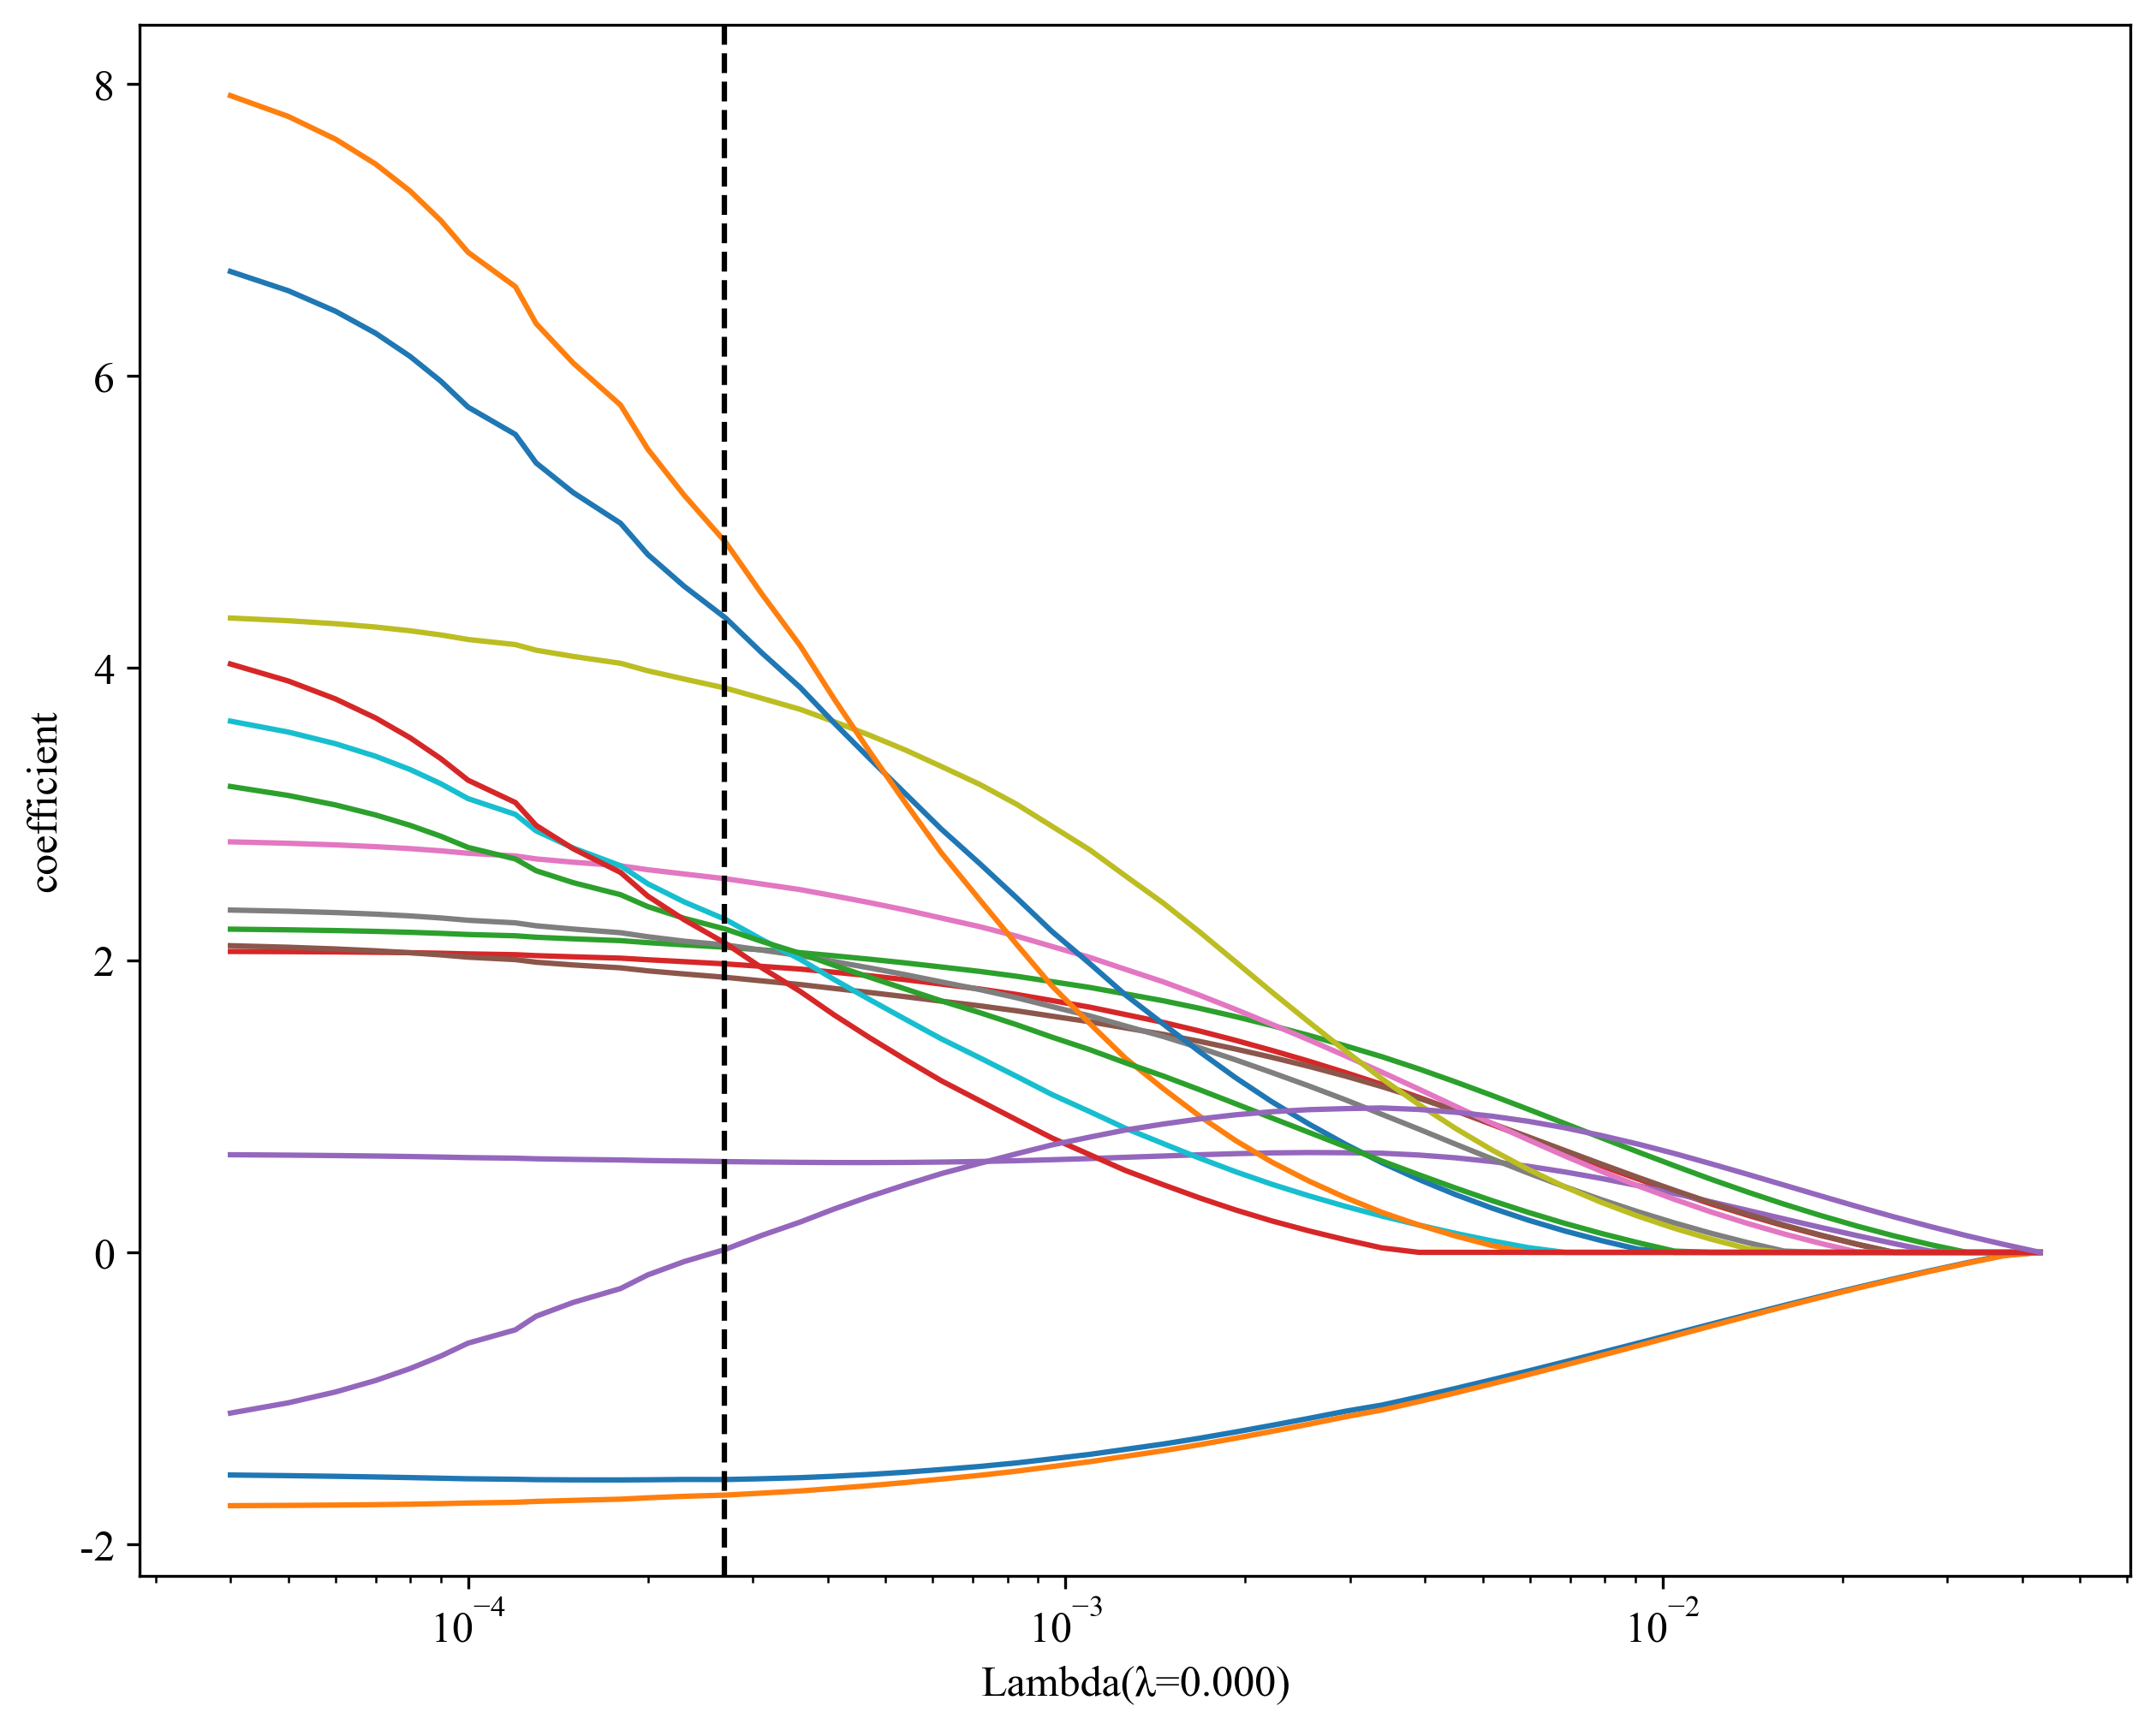

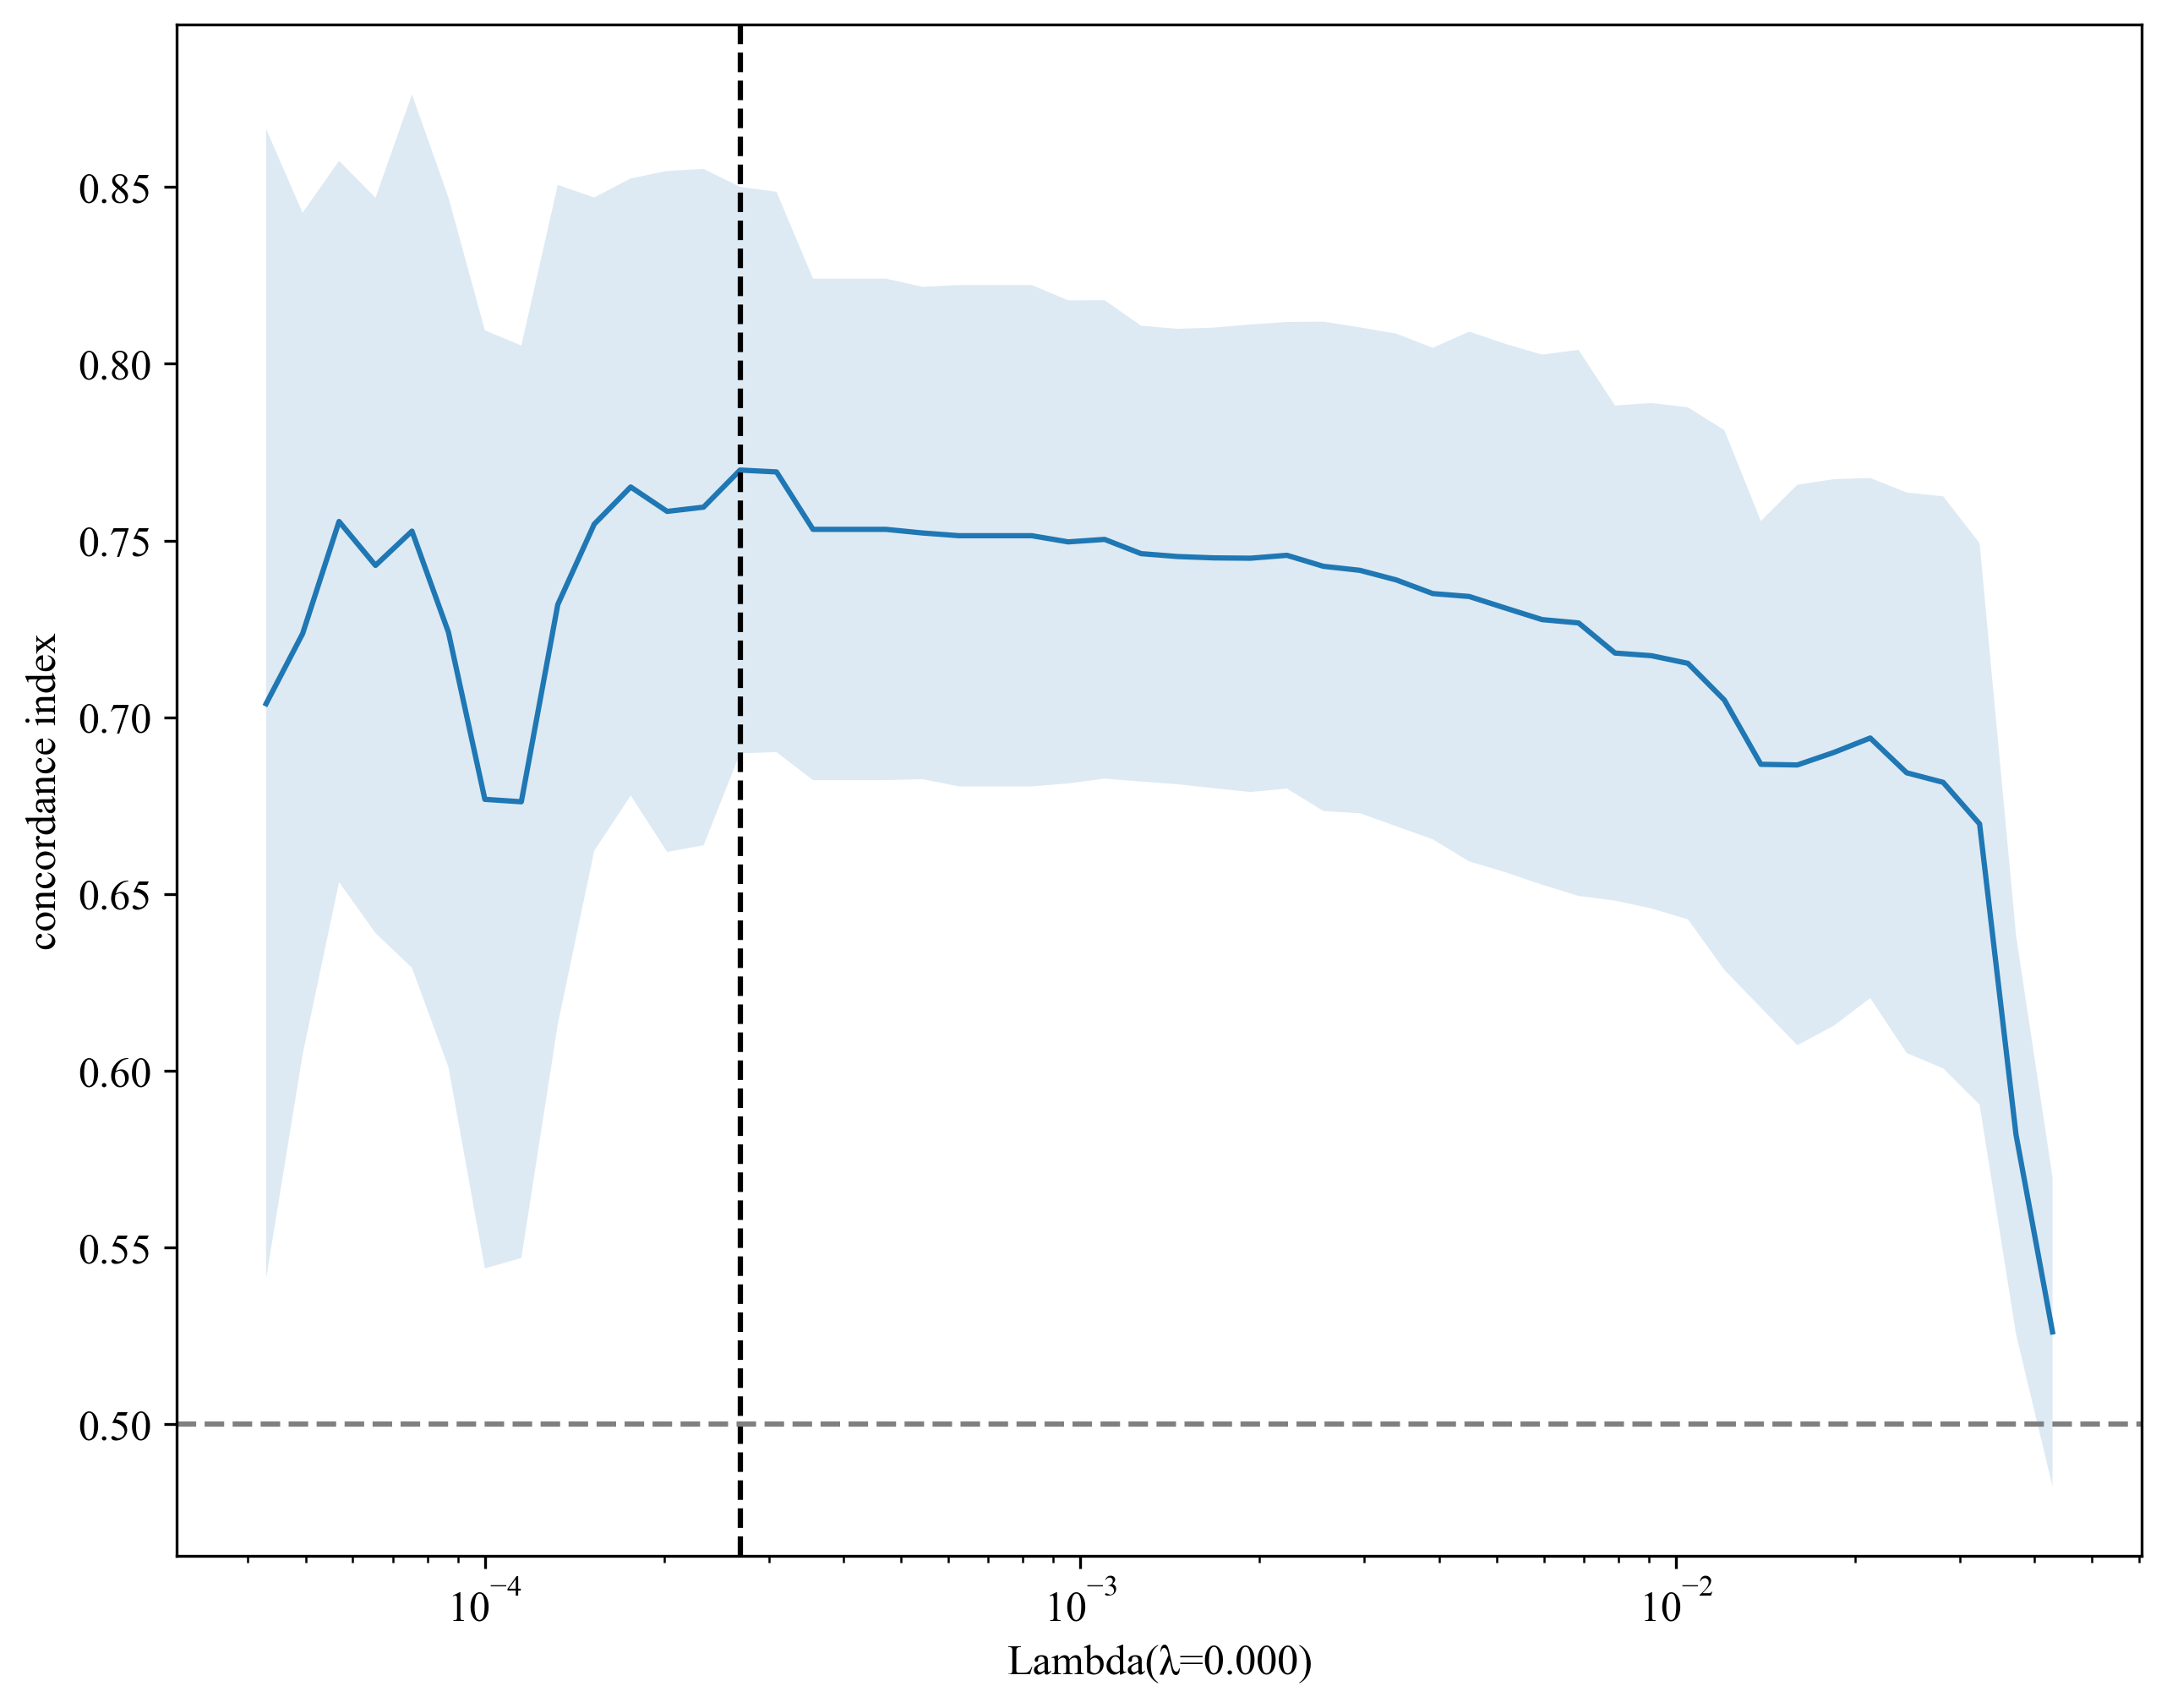

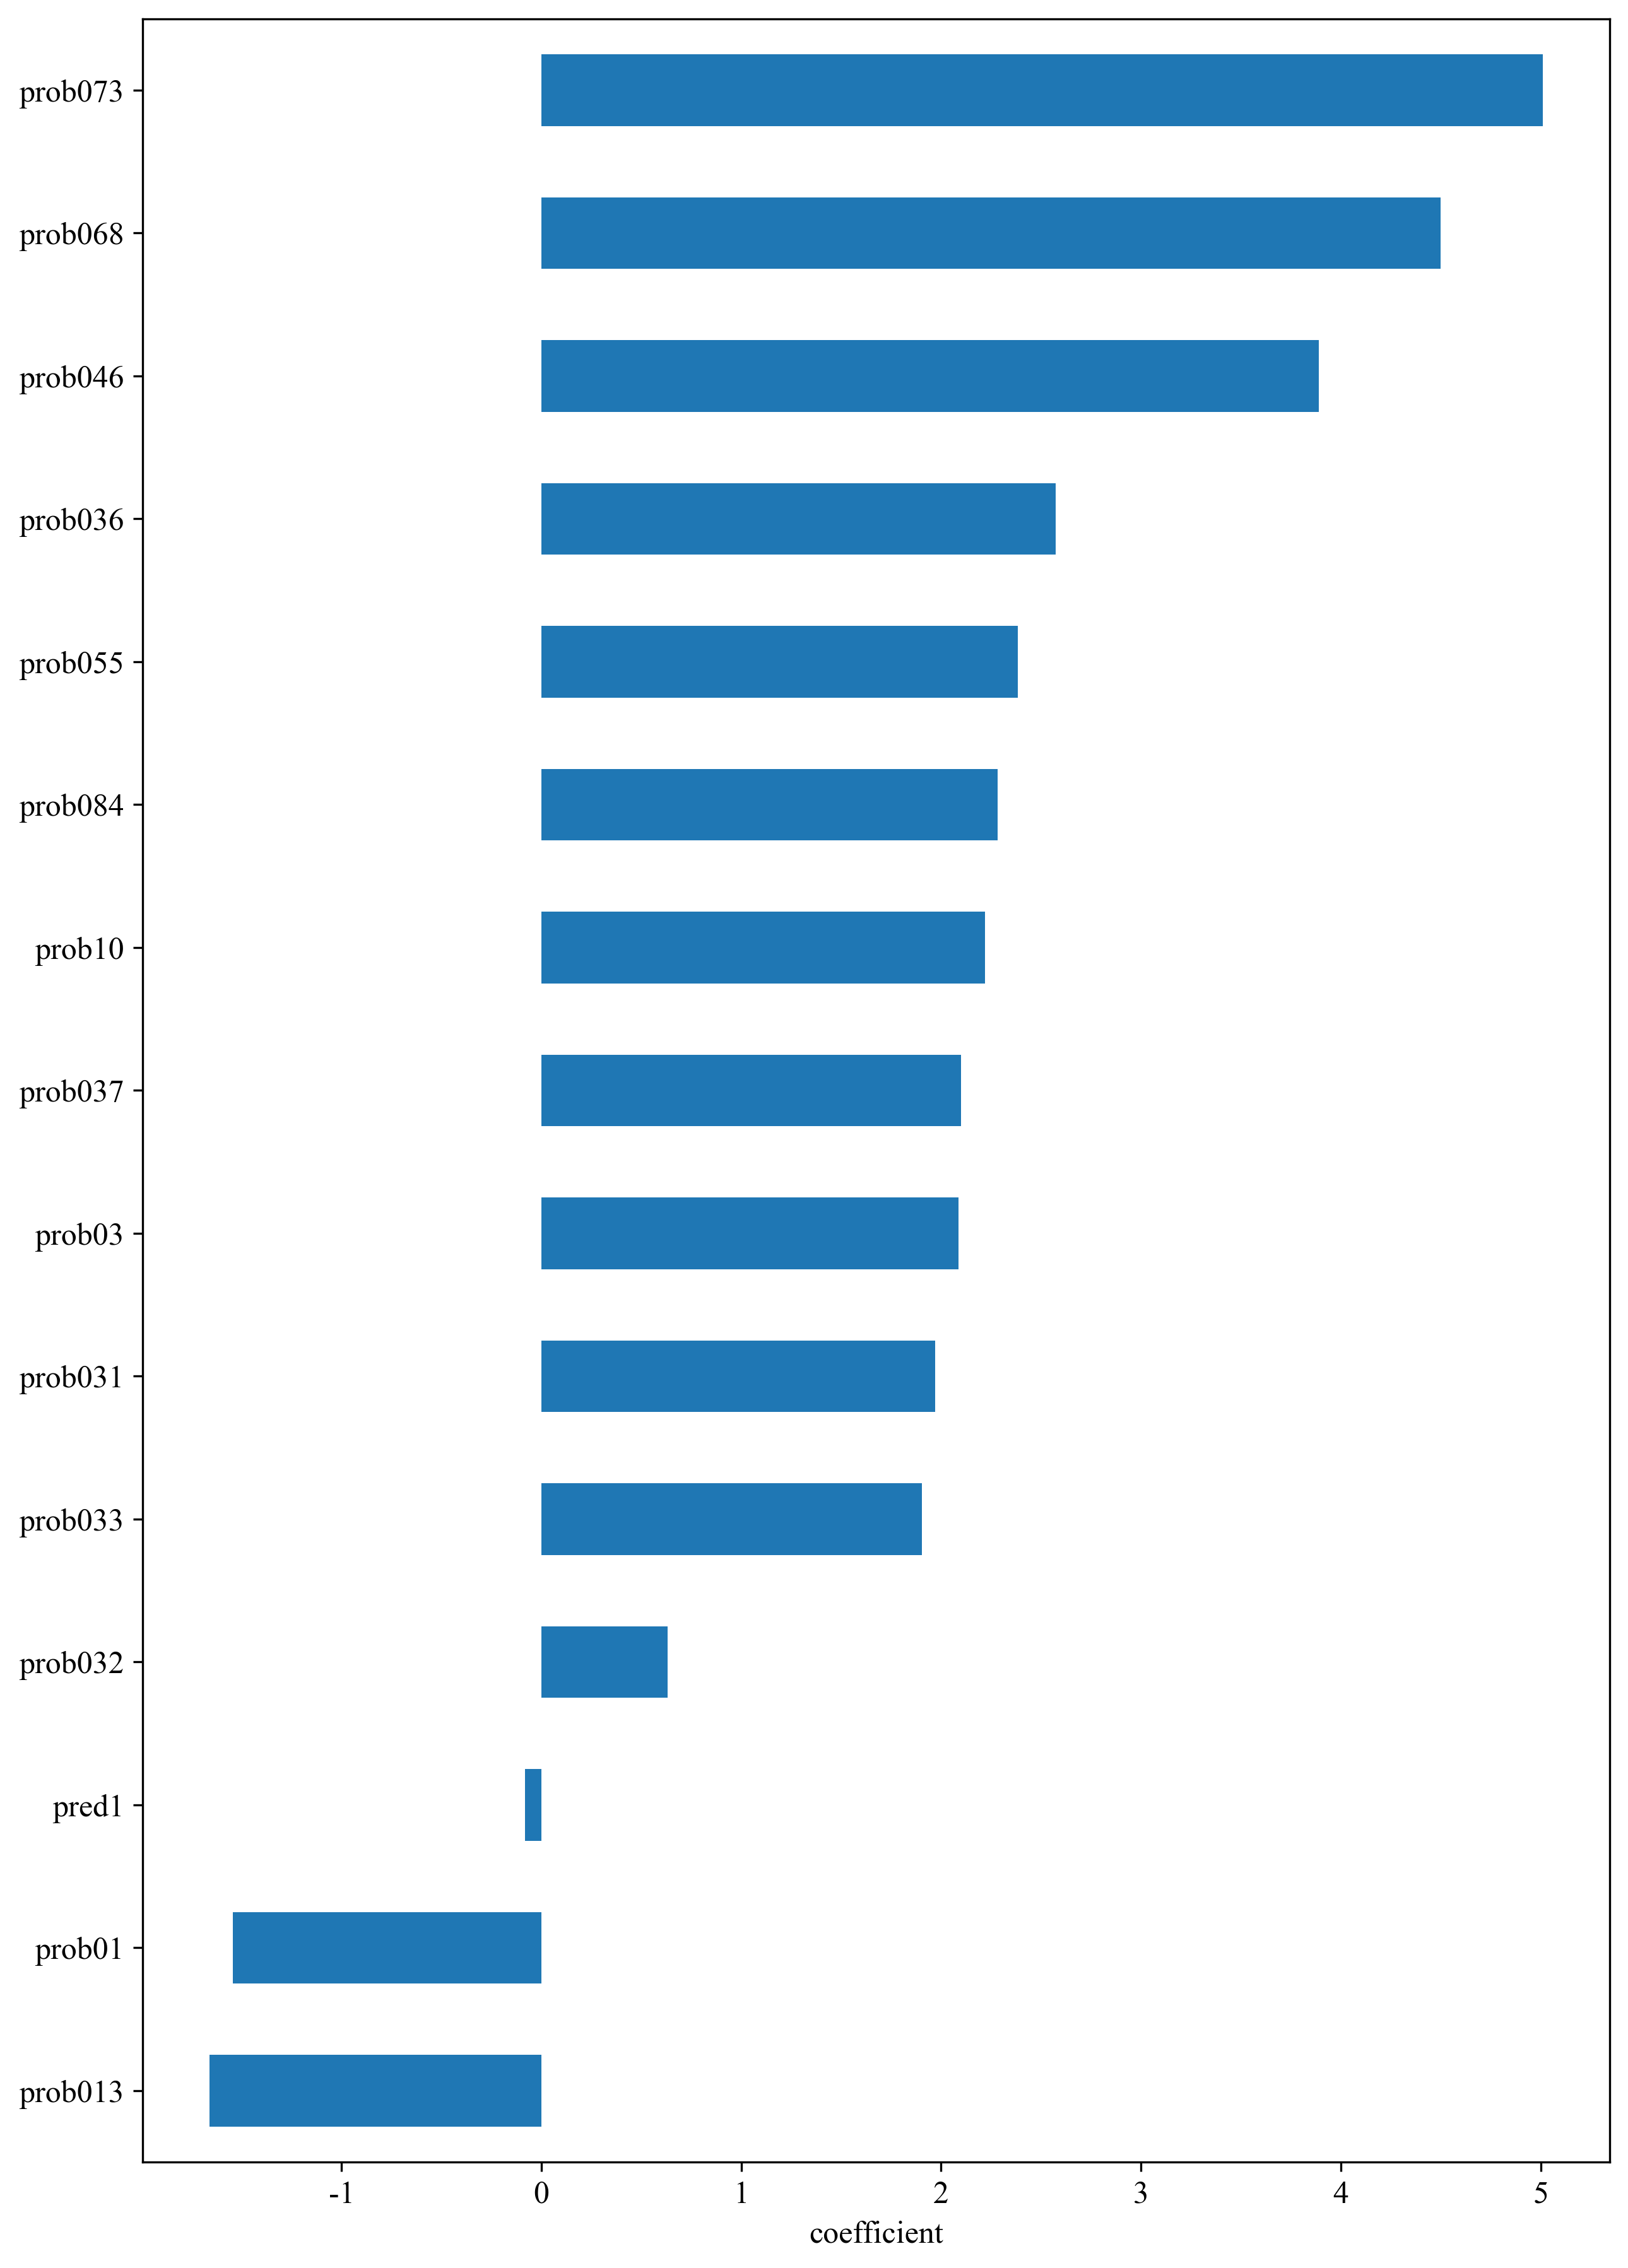

Survive = -1.662170 * prob013 -1.544285 * prob01 -0.082346 * pred1 +0.629923 * prob032 +1.902828 * prob033 +1.970201 * prob031 +2.087840 * prob03 +2.099464 * prob037 +2.218097 * prob10 +2.282327 * prob084 +2.384262 * prob055 +2.573900 * prob036 +3.889796 * prob046 +4.498783 * prob068 +5.011268 * prob073


In [7]:
from onekey_algo.custom.components.survival import get_x_y_survival, lasso_cox_cv
COEF_THRESHOLD = 1e-6

X, y = get_x_y_survival(train_data, val_outcome=1, event_col=event_col, duration_col=duration_col)
sel_features = lasso_cox_cv(X, y, max_iter=100,  norm_X=False, prefix=f"{task_type}", l1_ratio=0.3, cv=10, weights_fig_size=(10, 15))
# sel_features = lasso_cox_cv(X, y, max_iter=1000,  norm_X=False, prefix=f"{task}_", l1_ratio=0.8, cv=10)

In [8]:
train_data = train_data[['ID'] + list(sel_features.index) + [event_col, duration_col]]
for subset in subsets:
    val_datasets[subset] = val_datasets[subset][['ID'] + list(sel_features.index) + [event_col, duration_col]]
    val_datasets[subset].to_csv(f'features/{task_type}{subset}_cox.csv', index=False)

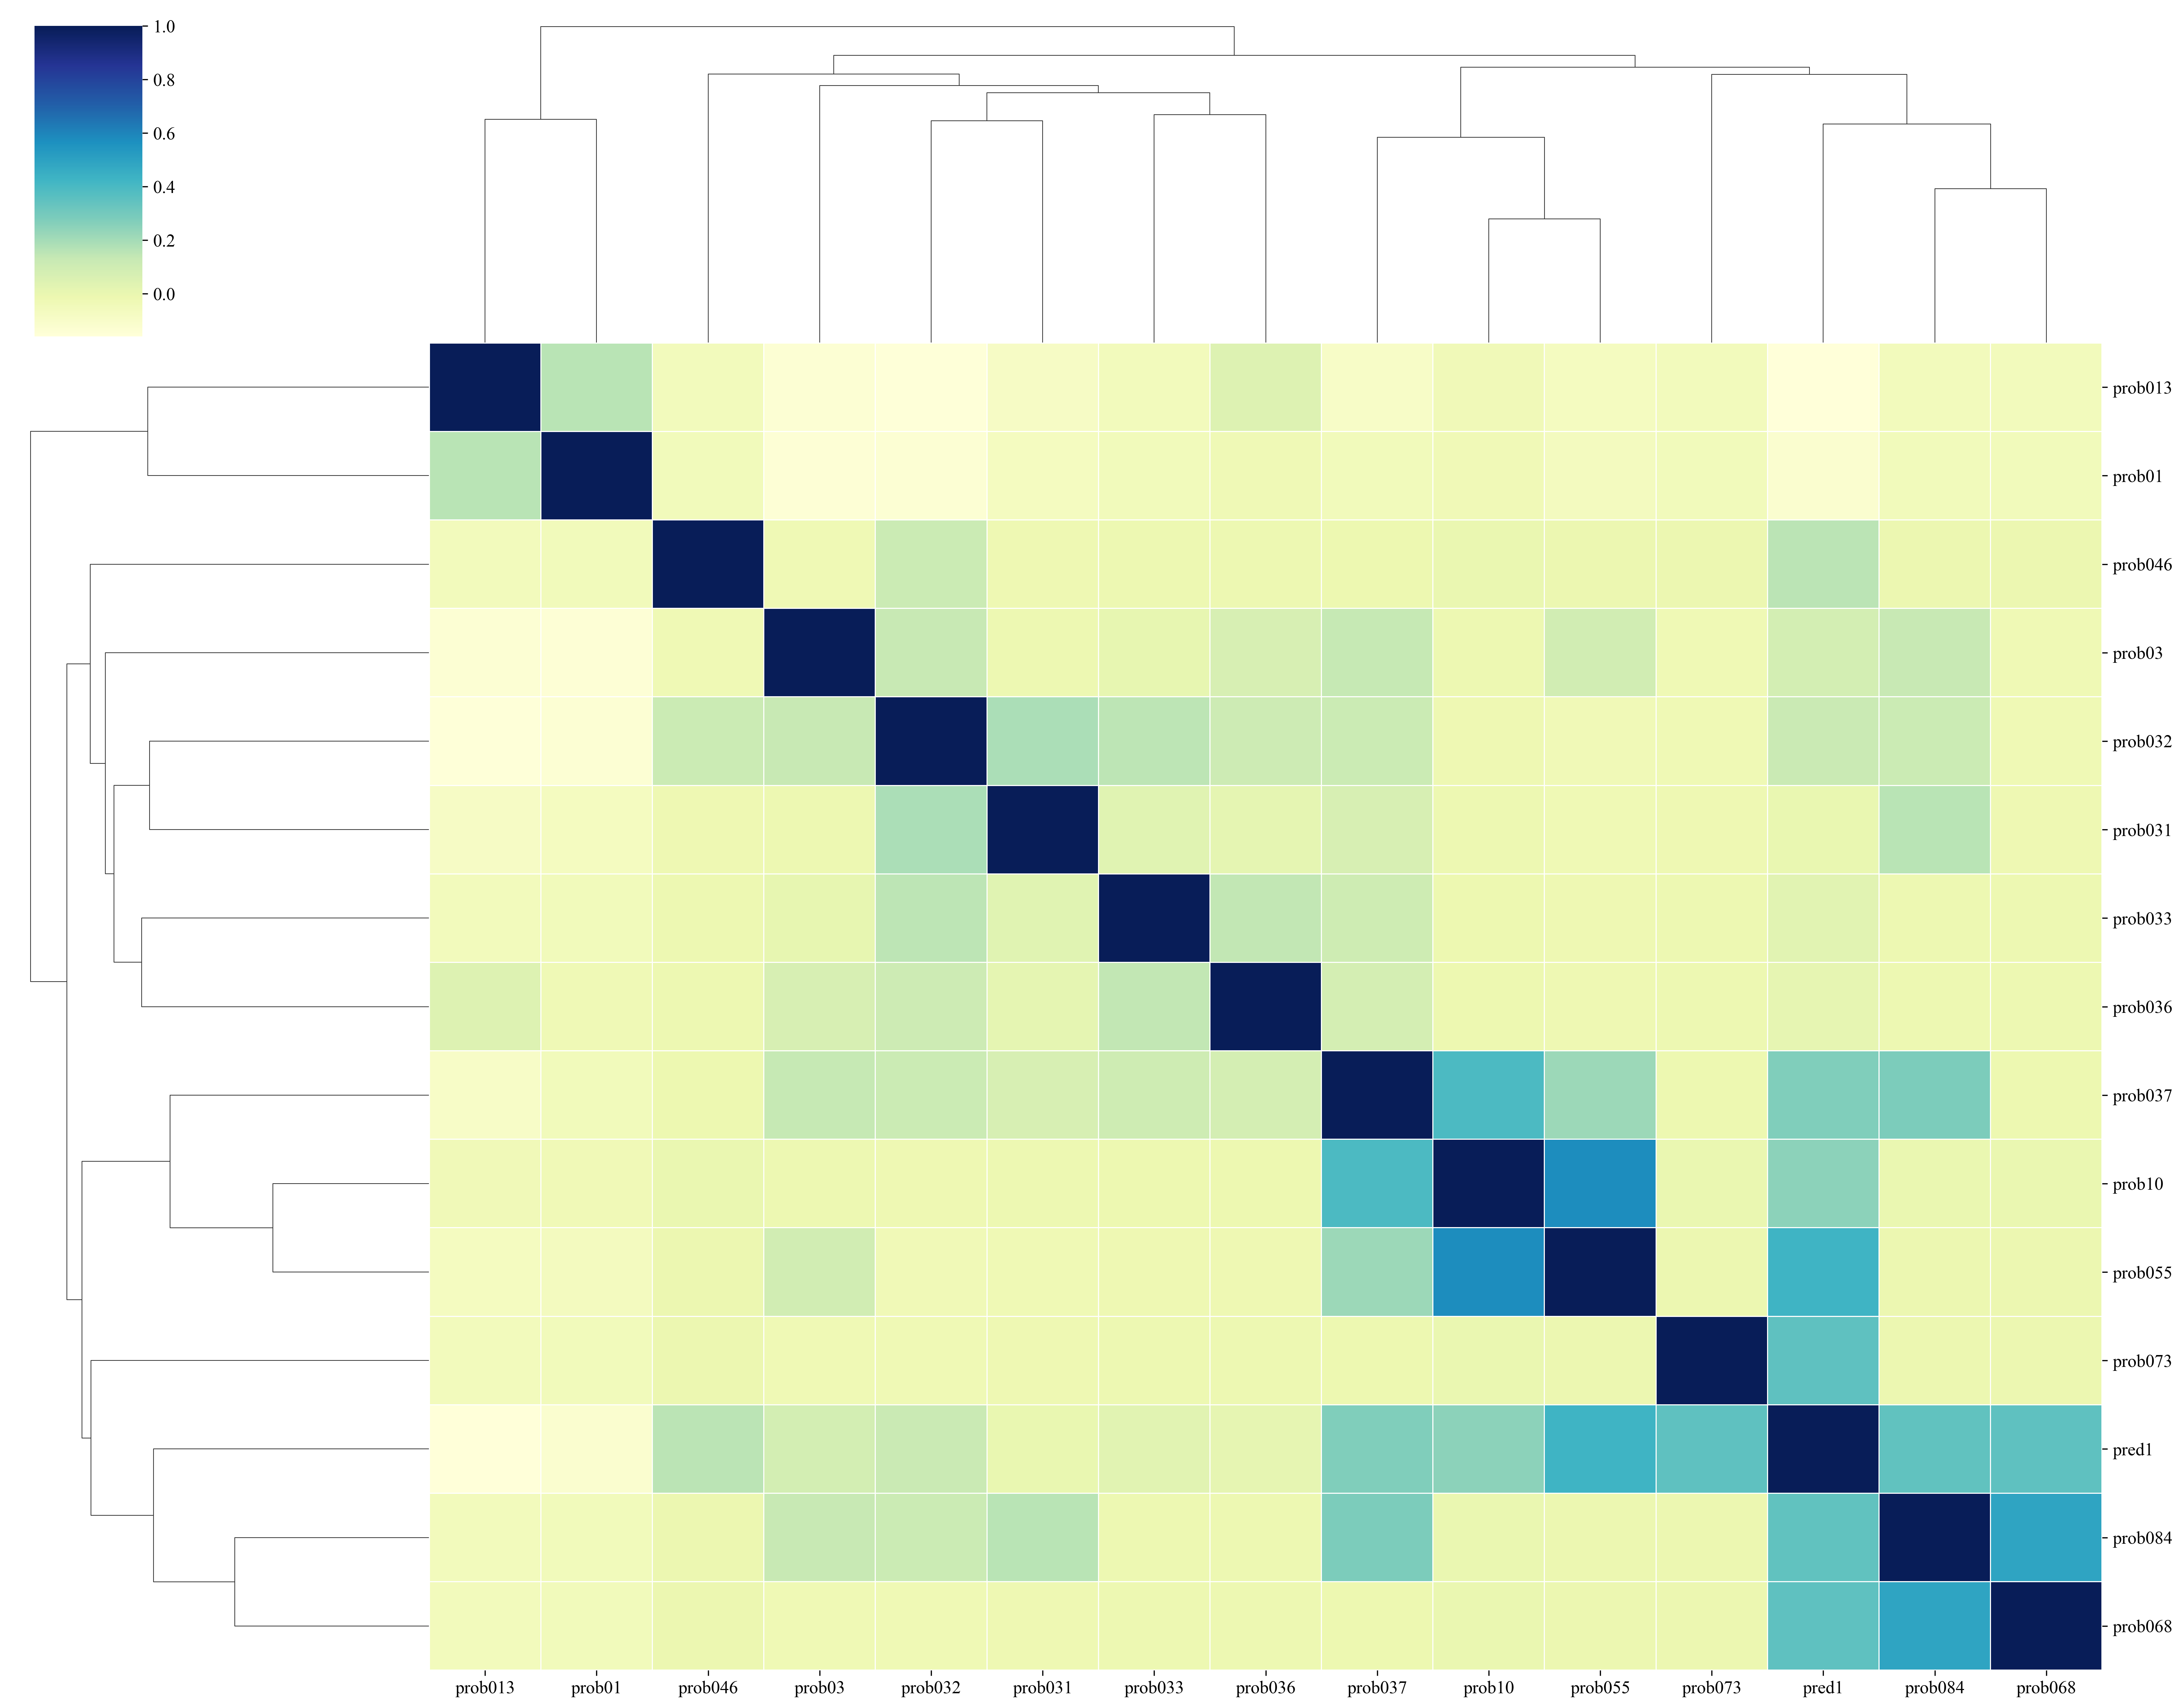

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

if train_data.shape[1] < 150:
    pp = sns.clustermap(train_data[[c for c in train_data.columns if c not in [event_col, duration_col]]].corr(corr_name), 
                        linewidths=.5, figsize=(20.0, 16.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}feature_cluster.svg', bbox_inches = 'tight')

## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [10]:
# from lifelines import CoxPHFitter
# mci = 0
# for p in range(1, 100):
#     cph = CoxPHFitter(penalizer=p/100)
#     cph.fit(train_data[[c for c in train_data.columns if c != 'ID']], duration_col=duration_col, event_col=event_col)
#     test_data = val_datasets['test']
#     ci = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     if mci < ci:
#         print(p, ci)
#         mci = ci

In [11]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.16)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group']]], duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 268 total observations, 214 right-censored observations>
             duration col = 'OSTIME'
                event col = 'OS'
                penalizer = 0.16
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 268
number of events observed = 54
   partial log-likelihood = -269.90
         time fit was run = 2024-09-15 15:50:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
prob013    -0.87       0.42       0.66            -2.16             0.43                 0.11                 1.54
prob01     -0.81       0.44       0.68            -2.14             0.52                 0.12                 1.68
pred1       0.09       1.10       0.61            -1.11             1.29                 0.33                 3.64
prob032     0.73       2.07       0.72            -0.69             2.15                 0.50                 8.55
prob033     1.60       4.97       0.86            -0.07             3.28                 0.93                26.61
prob031     1.45       4.27       0.84            -0.20             3.10                 0.82                22.23
prob03      1.53       4.60       0.76             0.03             3.02                 1.03                20.53
prob037     1.83       6.26       1.35            -0.81             4.48                 0.45                87.82
prob10      2.73      15.36       3.12            -3.38             8.84                 0.03              6893.62
prob084     2.65      14.12       1.82            -0.91             6.21                 0.40               497.48
prob055     1.97       7.18       1.94            -1.82             5.76                 0.16               318.86
prob036     1.82       6.15       0.91             0.03             3.60                 1.03                36.73
prob046     3.47      32.02       1.22             1.08             5.85                 2.95               347.17
prob068     3.80      44.68       1.93             0.01             7.59                 1.01              1977.49
prob073     4.10      60.58       2.37            -0.53             8.74                 0.59              6262.74

            cmp to     z      p   -log2(p)
covariate                                 
prob013       0.00 -1.31   0.19       2.39
prob01        0.00 -1.19   0.23       2.11
pred1         0.00  0.15   0.88       0.18
prob032       0.00  1.01   0.31       1.68
prob033       0.00  1.87   0.06       4.04
prob031       0.00  1.72   0.08       3.56
prob03        0.00  2.00   0.05       4.46
prob037       0.00  1.36   0.17       2.53
prob10        0.00  0.88   0.38       1.39
prob084       0.00  1.46   0.15       2.78
prob055       0.00  1.02   0.31       1.70
prob036       0.00  1.99   0.05       4.43
prob046       0.00  2.85 <0.005       7.84
prob068       0.00  1.96   0.05       4.34
prob073       0.00  1.73   0.08       3.59
---
Concordance = 0.76
Partial AIC = 569.81
log-likelihood ratio test = 41.87 on 15 df
-log2(p) of ll-ratio test = 12.06

#### 输出每个特征的HR

In [12]:
cph.concordance_index_

0.7565026507620941

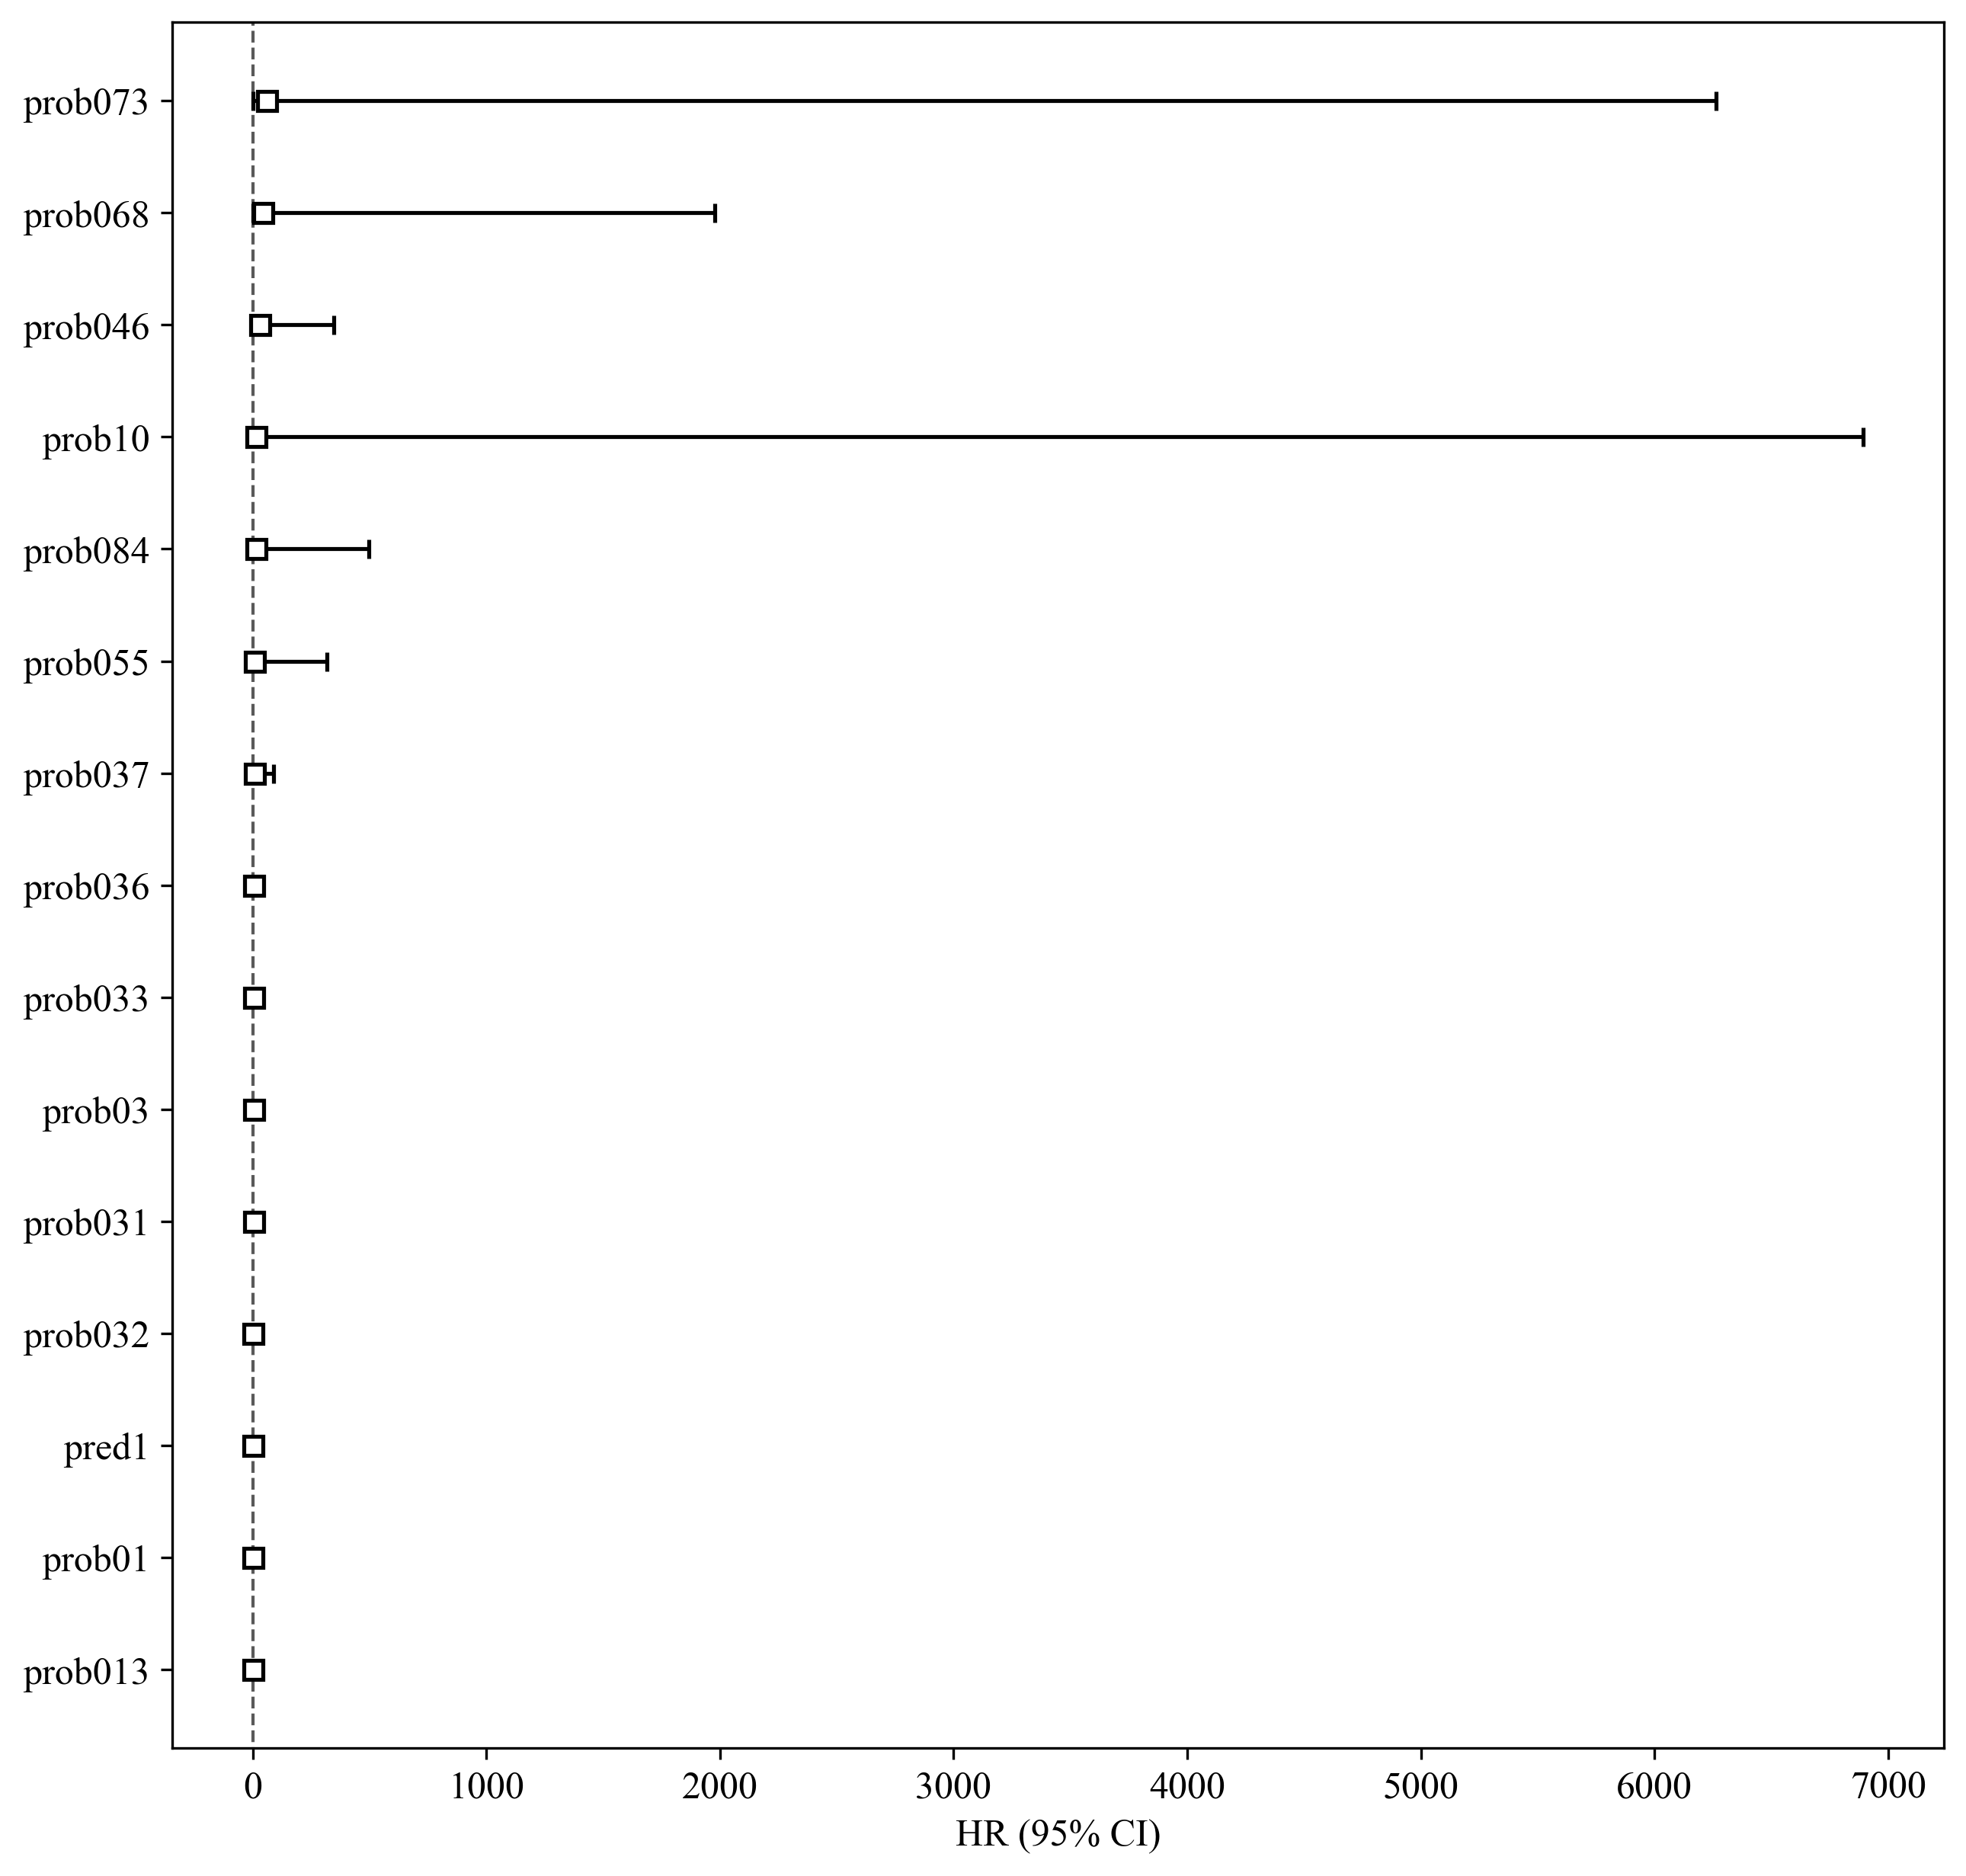

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
cph.plot(hazard_ratios=True)
plt.savefig('img/Clinic_feature_pvalue.svg')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

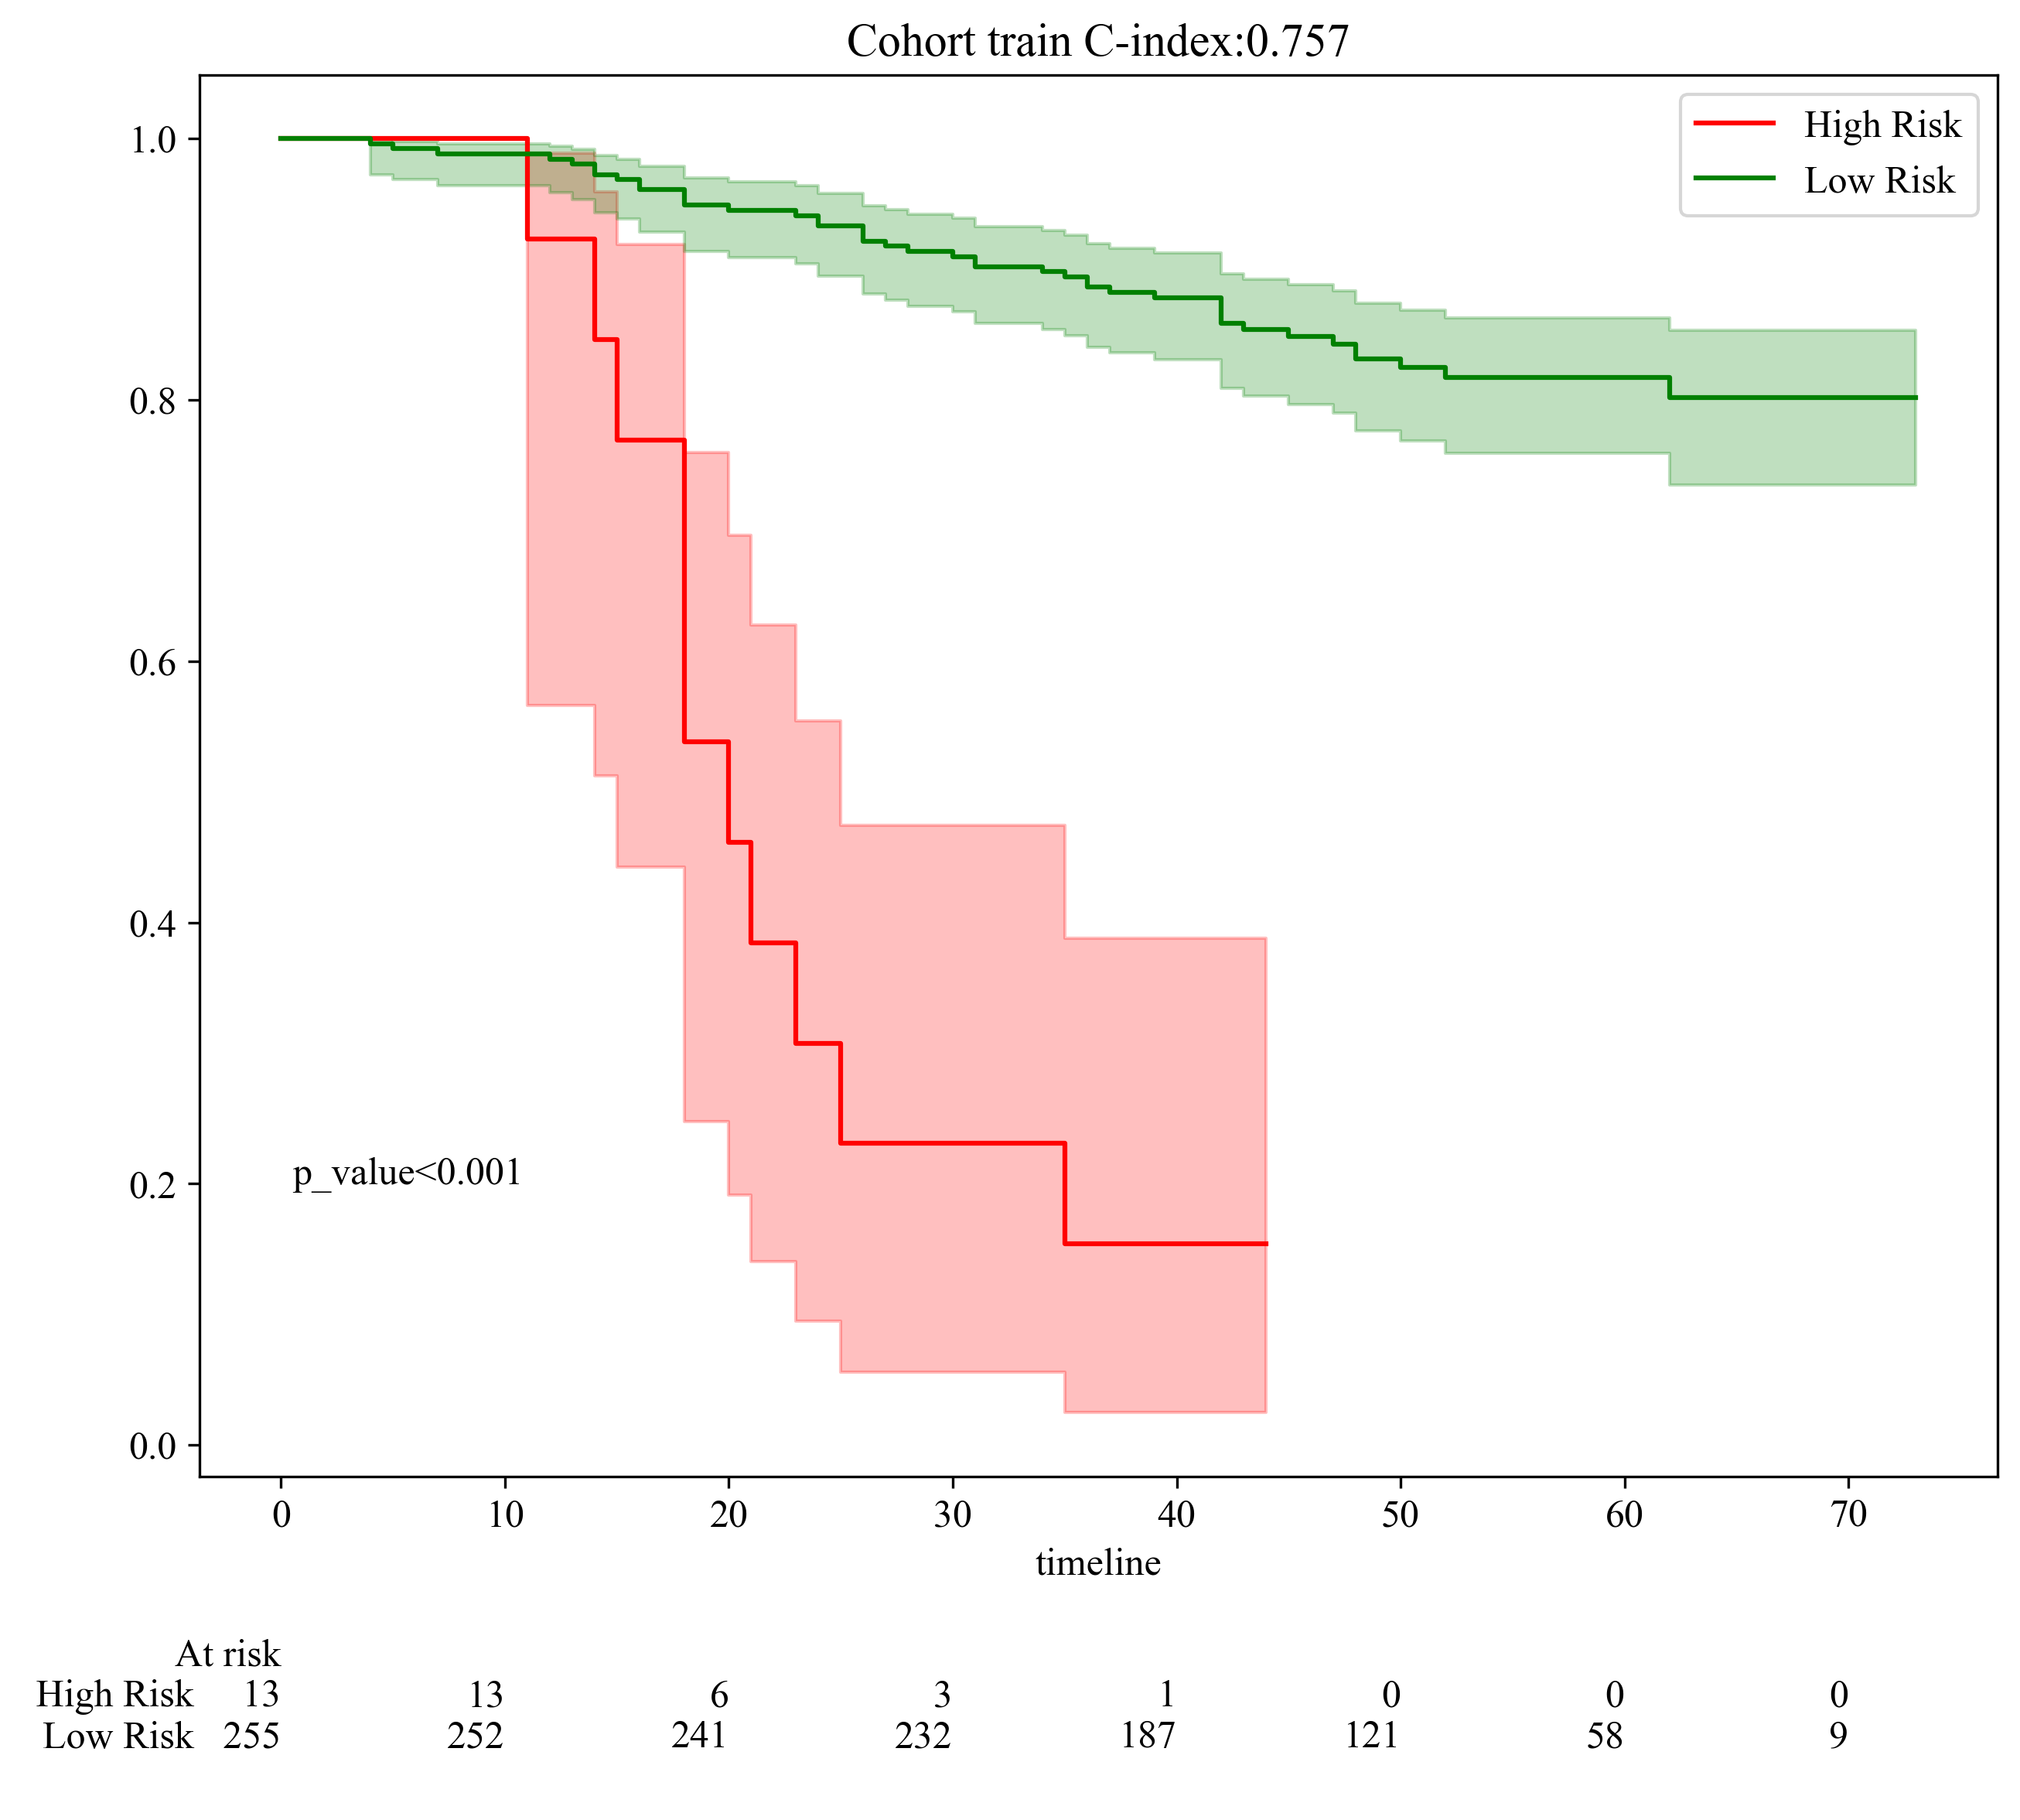

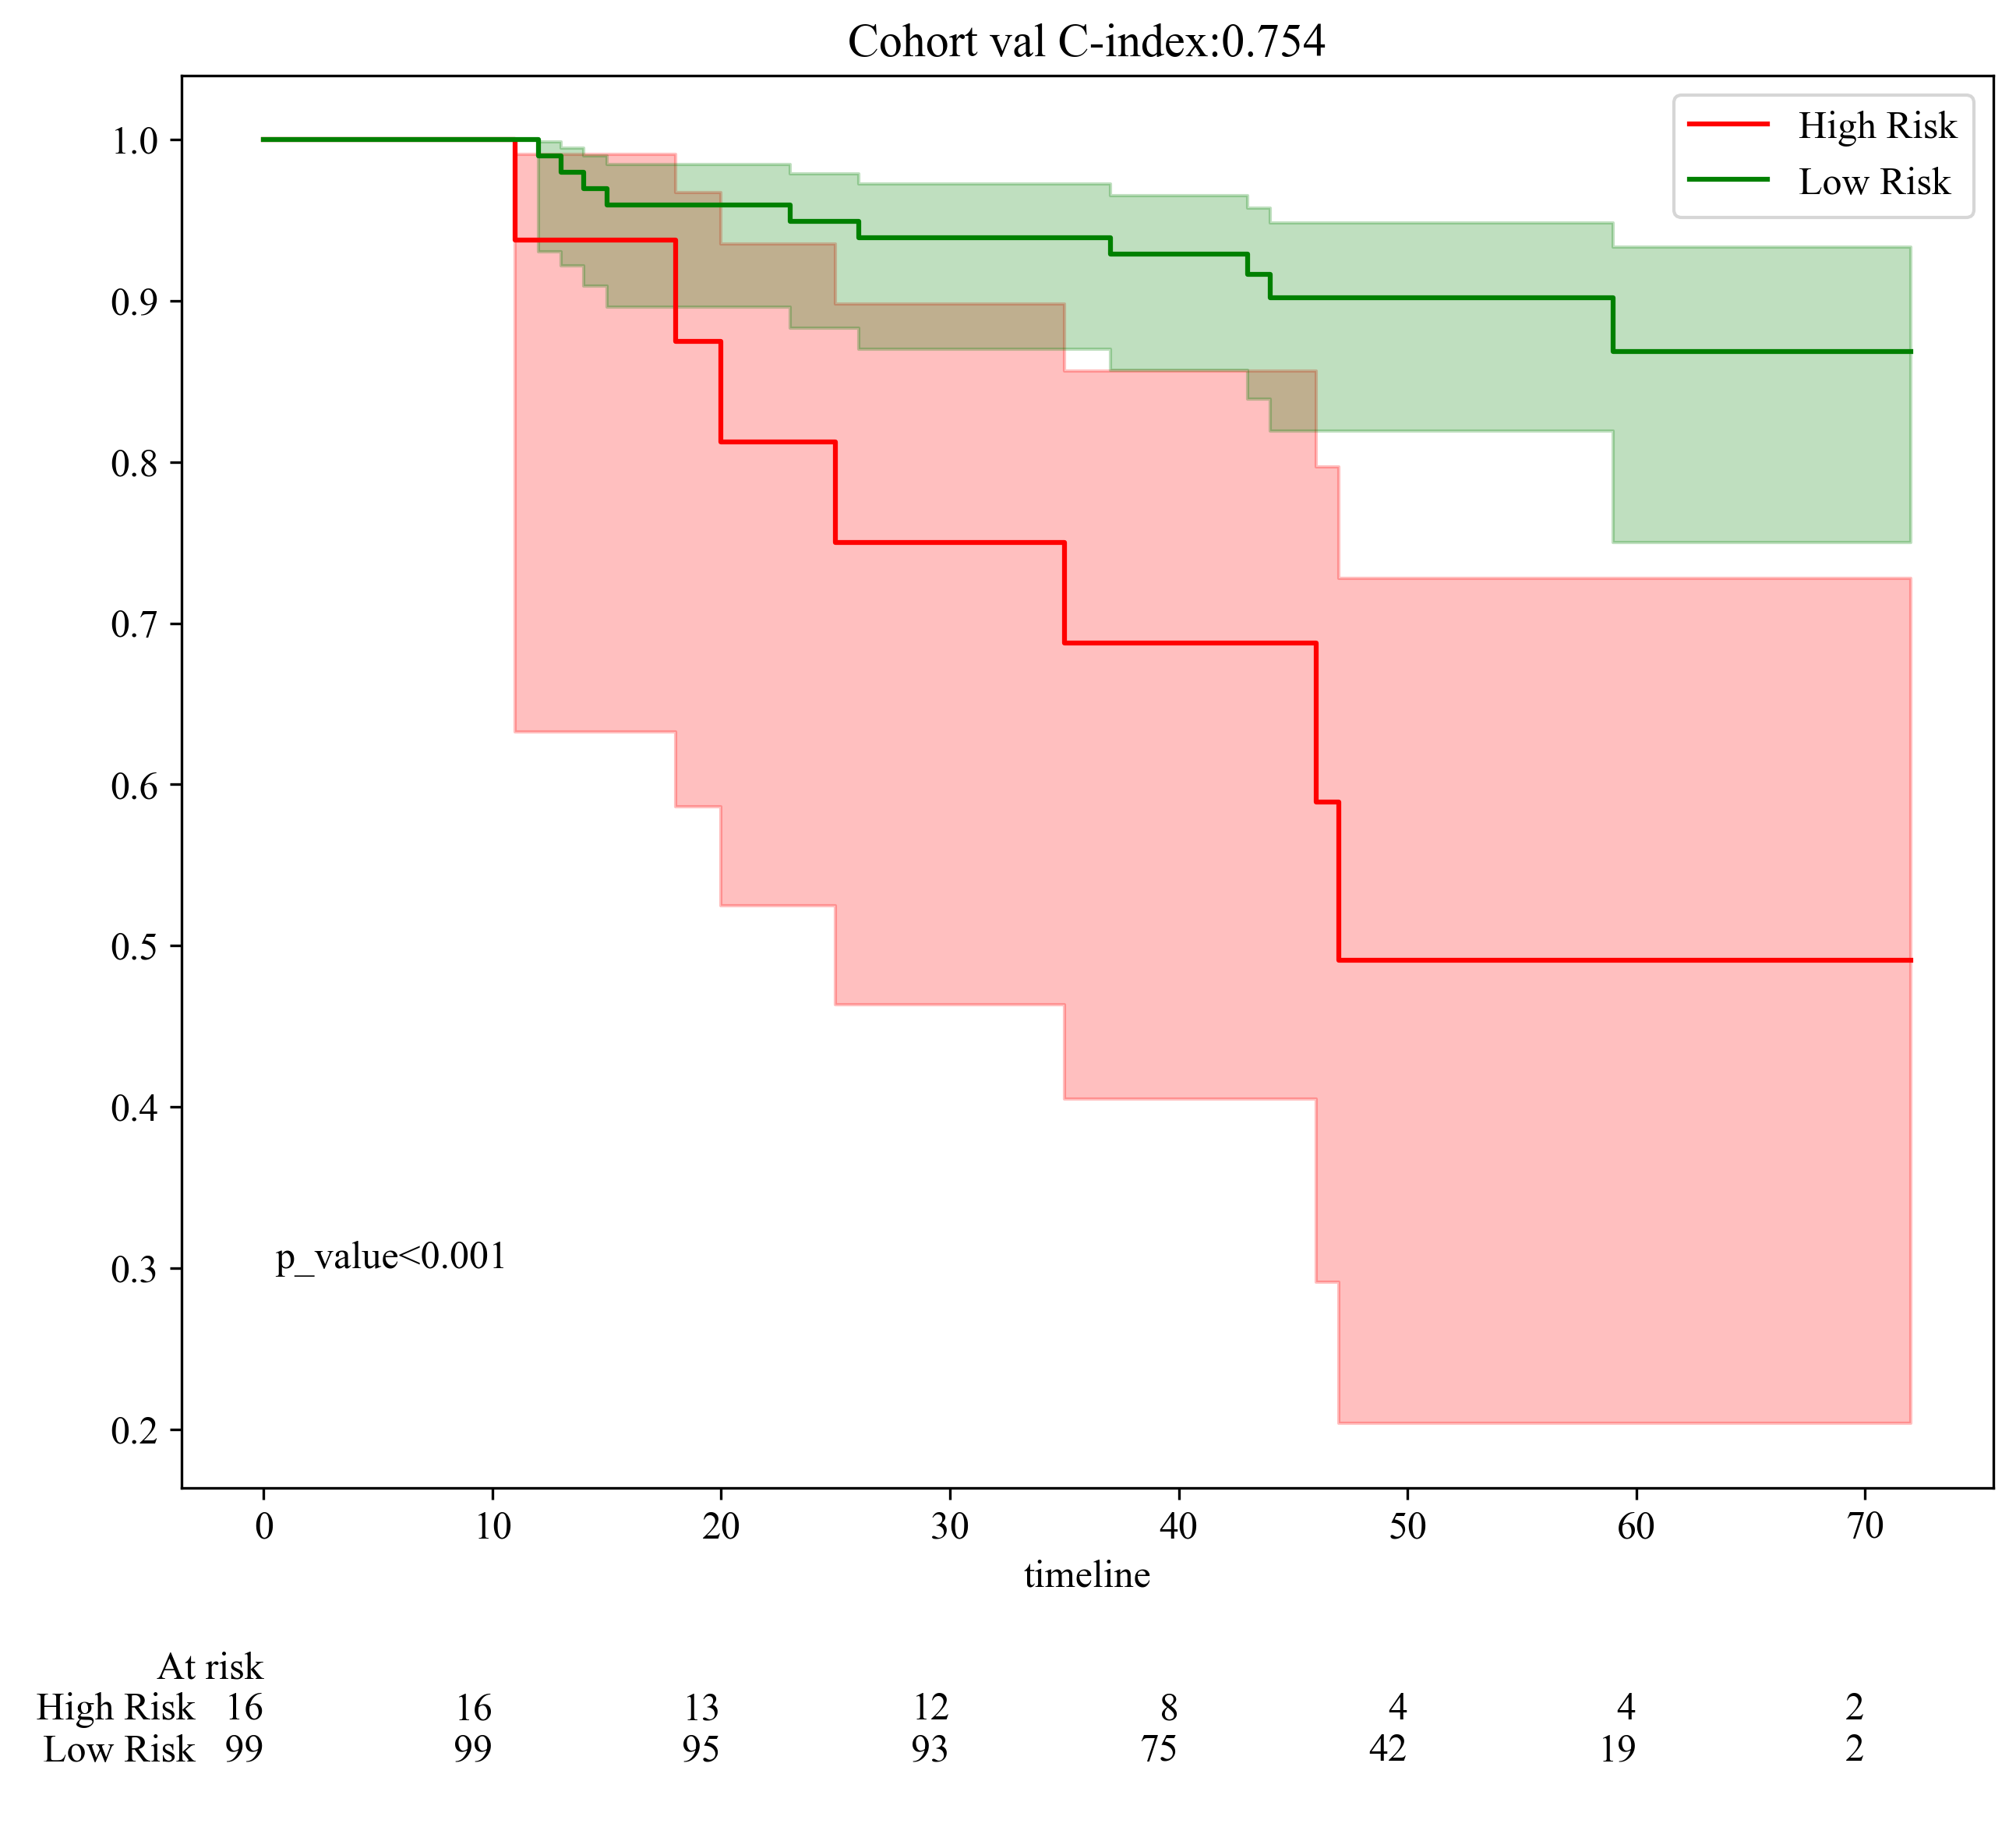

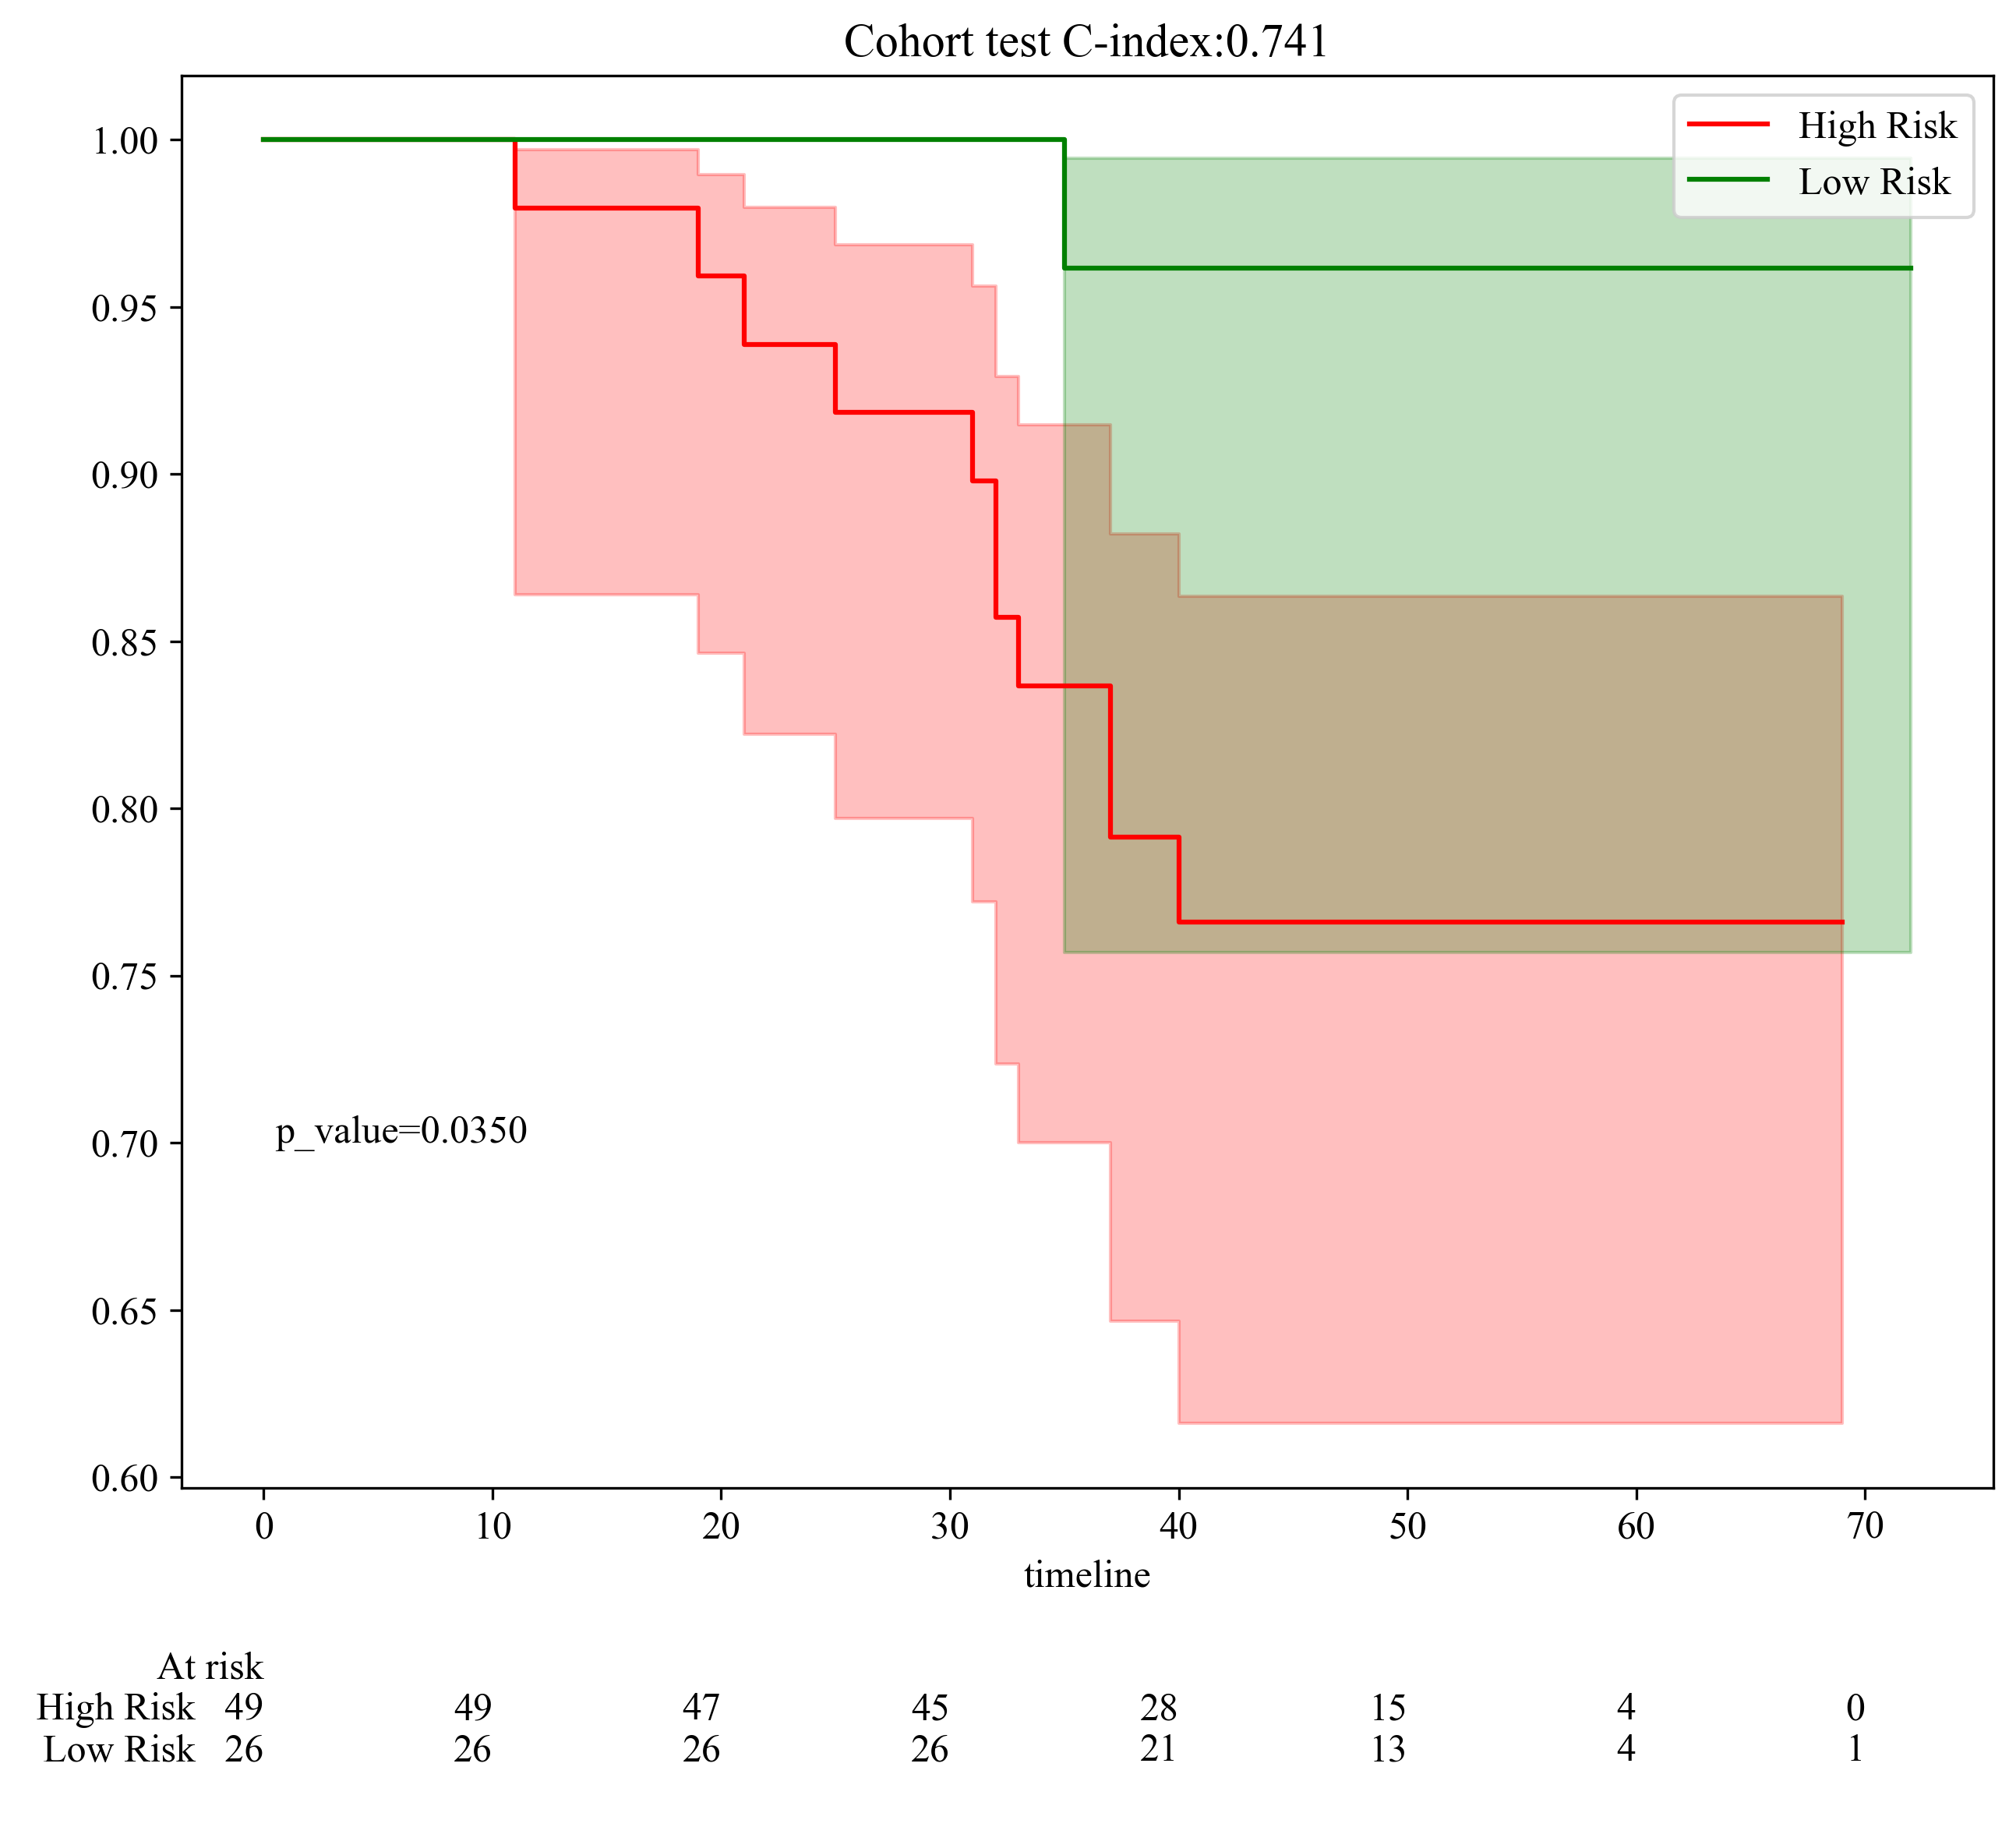

In [19]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts

thres = 0.001
bst_split = {'train': 4.32, 'val':0.98, 'test': 0.89}
loc = {'train': 0.2, 'val':0.3, 'test': 0.7}
for subset, test_data in val_datasets.items():
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > bst_split[subset]
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = f"={results.p_value:.4f}" if results.p_value > thres else f'<{thres}'
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    plt.text(0.5, loc[subset], f"p_value{p_value}")
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()

In [16]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions

os.makedirs('results', exist_ok=True)
info = []
for subset, test_data in val_datasets.items():
    if subset in get_param_in_cwd('subsets'):
        results = get_prediction(cph, test_data, ID=test_data['ID'])
        results.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
        results['group'] = subset
        info.append(results)
        pd.merge(results, data[['ID', event_col, duration_col]], 
                 on='ID', how='inner').to_csv(f'features/{task_type}4xtile_{subset}.txt', index=False, sep='\t')
info = pd.concat(info, axis=0)
info

,ID,HR,expectation,group
0,primary-1.nii.gz,13.963,18.307,train
1,primary-10.nii.gz,0.717,62.386,train
2,primary-100.nii.gz,0.891,60.913,train
4,primary-102.nii.gz,5.045,36.825,train
6,primary-104.nii.gz,1.540,55.831,train
...,...,...,...,...
453,secondary2-69.nii.gz,0.773,61.906,test
454,secondary2-7.nii.gz,0.399,65.211,test
455,secondary2-71.nii.gz,0.684,62.673,test
456,secondary2-72.nii.gz,0.683,62.682,test


In [17]:
# info[['ID', 'group']].to_csv('group.csv', index=False)